****Mount Drive****

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


****Setting Project Workspace****

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/session9')


In [3]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA4/session9/*

'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/gradcam.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/main.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/main.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/readme'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/train_test.py'

'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/dataloader':
dataset_loader.py  data_transform.py  __pycache__

'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/images':
snake.JPEG

'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/Models':
model.py  __pycache__  resnet.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/session9/__pycache__':
gradcam.cpython-36.pyc	train_test.cpython-36.pyc


In [4]:
!pip install albumentations
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm

import train_test as tt
from Models import resnet

from dataloader.dataset_loader import get_dataloader
from dataloader import data_transform as data_transform
from gradcam import GradCAM, visualize_cam

from torchvision.utils import make_grid, save_image

     |████████████████████████████████| 634kB 4.9MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=877ff5e5cbf622c2c4b68623ade4083c50db678a42e7d3468376bfbedabd7052
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


****Loading data****

In [5]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

## getting training data loader
#trainloader = Datasetloader(True, cuda).trainloader()

## getting test data loader
#testloader = Datasetloader(False, cuda).testloader()




## getting training data loader
trainloader = get_dataloader(True, cuda)

## getting test data loader
testloader = get_dataloader(False, cuda)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


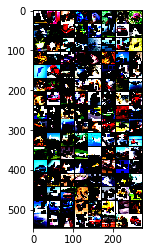

In [6]:
type(trainloader)

#get some random training images
dataiter = iter(trainloader)
#print(dataiter)
images, labels = dataiter.next()
images.size()


def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    
# show images
show(torchvision.utils.make_grid(images))

****Initializing Network Architecture****

In [7]:
!pip install torchsummary
from torchsummary import summary
mod = resnet.ResNet18().to(device)
summary(mod, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
from __future__ import print_function
import torch
from tqdm import tqdm

# model training
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_acc = []

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        max_prob = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += max_prob.eq(target.view_as(max_prob)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

****Model training and Evaluation****

In [0]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mod.parameters(), lr=0.01, momentum=0.9)

# Model Training and Evaluation
for epoch in range(0, 40):
    tt.train(mod, device, trainloader, optimizer, epoch, criterion)
    tt.test(mod, device, testloader, criterion)


epoch=0 Loss=1.1442582607269287 Batch_id=390 Accuracy=43.65: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5786/10000 (57.9%)



epoch=1 Loss=0.8347253799438477 Batch_id=390 Accuracy=60.08: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 6128/10000 (61.3%)



epoch=2 Loss=0.689454197883606 Batch_id=390 Accuracy=67.50: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 7395/10000 (74.0%)



epoch=3 Loss=0.7736903429031372 Batch_id=390 Accuracy=71.58: 100%|██████████| 391/391 [00:33<00:00, 11.76it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7678/10000 (76.8%)



epoch=4 Loss=0.7945565581321716 Batch_id=390 Accuracy=74.82: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7930/10000 (79.3%)



epoch=5 Loss=0.49127984046936035 Batch_id=390 Accuracy=77.13: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7667/10000 (76.7%)



epoch=6 Loss=0.5379471182823181 Batch_id=390 Accuracy=78.80: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8260/10000 (82.6%)



epoch=7 Loss=0.5704718828201294 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8268/10000 (82.7%)



epoch=8 Loss=0.39483585953712463 Batch_id=390 Accuracy=82.01: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8304/10000 (83.0%)



epoch=9 Loss=0.733266294002533 Batch_id=390 Accuracy=83.00: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8368/10000 (83.7%)



epoch=10 Loss=0.4451747536659241 Batch_id=390 Accuracy=84.03: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8524/10000 (85.2%)



epoch=11 Loss=0.32789045572280884 Batch_id=390 Accuracy=84.87: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8543/10000 (85.4%)



epoch=12 Loss=0.3995450437068939 Batch_id=390 Accuracy=85.74: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8582/10000 (85.8%)



epoch=13 Loss=0.44969409704208374 Batch_id=390 Accuracy=86.59: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8378/10000 (83.8%)



epoch=14 Loss=0.35805225372314453 Batch_id=390 Accuracy=87.09: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8596/10000 (86.0%)



epoch=15 Loss=0.3966071307659149 Batch_id=390 Accuracy=87.40: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8576/10000 (85.8%)



epoch=16 Loss=0.32265233993530273 Batch_id=390 Accuracy=88.19: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8584/10000 (85.8%)



epoch=17 Loss=0.33735260367393494 Batch_id=390 Accuracy=88.94: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8596/10000 (86.0%)



epoch=18 Loss=0.37249836325645447 Batch_id=390 Accuracy=89.28: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8634/10000 (86.3%)



epoch=19 Loss=0.343988835811615 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8800/10000 (88.0%)



epoch=20 Loss=0.3312090039253235 Batch_id=390 Accuracy=90.22: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8811/10000 (88.1%)



epoch=21 Loss=0.2727327048778534 Batch_id=390 Accuracy=90.44: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8797/10000 (88.0%)



epoch=22 Loss=0.37160539627075195 Batch_id=390 Accuracy=91.05: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8734/10000 (87.3%)



epoch=23 Loss=0.43686676025390625 Batch_id=390 Accuracy=91.02: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8813/10000 (88.1%)



epoch=24 Loss=0.20280127227306366 Batch_id=390 Accuracy=91.65: 100%|██████████| 391/391 [00:32<00:00, 11.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8686/10000 (86.9%)



epoch=25 Loss=0.2058415710926056 Batch_id=390 Accuracy=91.68: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8828/10000 (88.3%)



epoch=26 Loss=0.19187797605991364 Batch_id=390 Accuracy=92.12: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8869/10000 (88.7%)



epoch=27 Loss=0.31200140714645386 Batch_id=390 Accuracy=92.32: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8814/10000 (88.1%)



epoch=28 Loss=0.3714391589164734 Batch_id=390 Accuracy=92.53: 100%|██████████| 391/391 [00:32<00:00, 11.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8884/10000 (88.8%)



epoch=29 Loss=0.273600697517395 Batch_id=390 Accuracy=92.66: 100%|██████████| 391/391 [00:32<00:00, 12.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8908/10000 (89.1%)



epoch=30 Loss=0.22834618389606476 Batch_id=390 Accuracy=92.83: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8940/10000 (89.4%)



epoch=31 Loss=0.2851621210575104 Batch_id=390 Accuracy=93.29: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8925/10000 (89.2%)



epoch=32 Loss=0.17678546905517578 Batch_id=390 Accuracy=93.45: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8929/10000 (89.3%)



epoch=33 Loss=0.17757003009319305 Batch_id=390 Accuracy=93.57: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8941/10000 (89.4%)



epoch=34 Loss=0.1420787274837494 Batch_id=390 Accuracy=93.62: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8990/10000 (89.9%)



epoch=35 Loss=0.20236115157604218 Batch_id=390 Accuracy=93.88: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8995/10000 (90.0%)



epoch=36 Loss=0.21379899978637695 Batch_id=390 Accuracy=94.01: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8972/10000 (89.7%)



epoch=37 Loss=0.18507984280586243 Batch_id=390 Accuracy=94.38: 100%|██████████| 391/391 [00:32<00:00, 11.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8945/10000 (89.5%)



epoch=38 Loss=0.14633458852767944 Batch_id=390 Accuracy=94.38: 100%|██████████| 391/391 [00:32<00:00, 12.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8993/10000 (89.9%)



epoch=39 Loss=0.13949912786483765 Batch_id=390 Accuracy=94.67: 100%|██████████| 391/391 [00:32<00:00, 11.97it/s]



Test set: Average loss: 0.0031, Accuracy: 8969/10000 (89.7%)



## GradCAM Implementation

In [31]:
dataiter_test = iter(testloader)
#print(dataiter)
test_images, test_labels = dataiter_test.next()
test_images.size()
test_images[1]
test_images.size()

torch.Size([128, 3, 32, 32])

Class:- plane


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


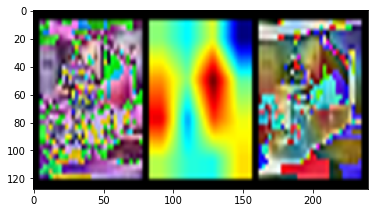

Class:- car


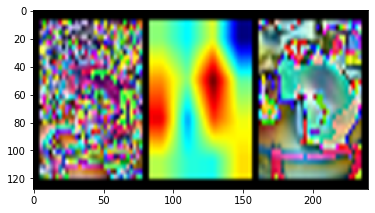

Class:- bird


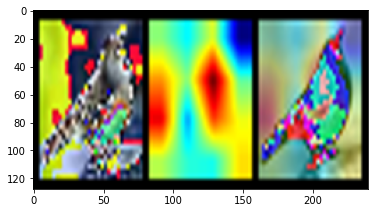

Class:- cat


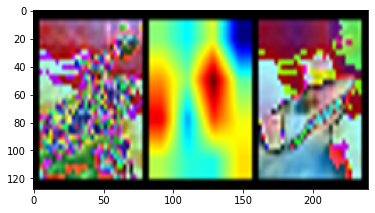

Class:- deer


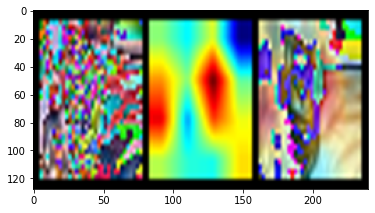

Class:- dog


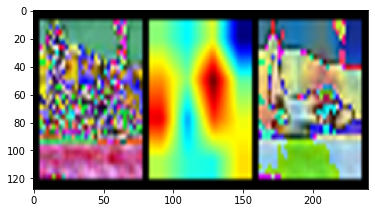

Class:- frog


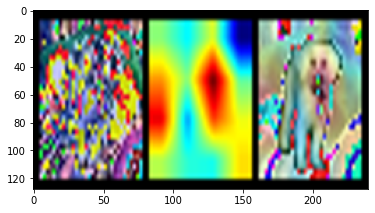

Class:- horse


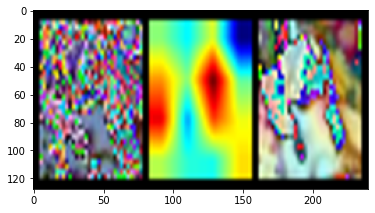

Class:- ship


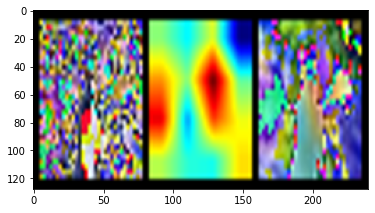

Class:- truck


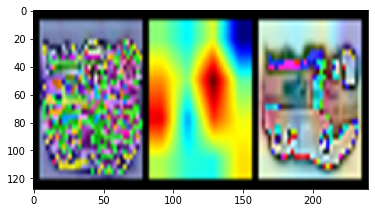

In [33]:
import matplotlib.pyplot as plt
#sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/session9')
newsize = (240, 128)
for idx, class_name in enumerate(classes):
  images = []
  output_img = ''
  grid_image = ''
  target_layers = ['layer4']
  
  for layers, module in mod.to(device).eval().named_modules():
      if layers in target_layers:
          gcam = GradCAM(mod.to(device).eval(), module)
          mask, _ = gcam(test_images[0:1, :, :, :].to(device))
          heatmap, result = visualize_cam(mask, test_images[idx])        
          images.extend([test_images[idx], heatmap, result])

  grid_image = make_grid(images, nrow=5) 
  output_img = transforms.ToPILImage()(grid_image).resize(newsize)
  print("Class:-",class_name)
  plt.imshow(output_img)
  plt.pause(0.0001)